# Dataset: Trackster neighborhood with PU

- select a trackster having at least 50% of the simtrackster energy (0.5 from the associator) and energy above 10GeV
- connect its barycenter to (0,0,0), that gives the trackster axis
- draw a cylinder along this axis, 10cm wide, going 3 layers (or 10cm) before and after the first/last layer-cluster
- connect to all tracksters with a barycenter within this cone (star-like labels)
- labels based on the associator score (can even be binary)
- start with photons, 90% of them are fine, we just wanna fix the remaining 10%
- if we are doing well here, we can go to pions which are much more fragmented
- cut off at 0.2 but can include events with no edges too

Physics evaluation
- plug it into the CMSSW

Method evaluation
- based on precision and recall
    - precision: 2 LC from RECO (within the cone?) also together in SIM
        - how much mess I got in?
    - recall: 2 LC from SIM together in RECO
        - how good did I do on the connecting?


In [1]:
import uproot
import numpy as np

import matplotlib.pyplot as plt

from reco.datasetPU import get_trackster_representative_points, get_tracksters_in_cone, get_major_PU_tracksters

ds_name = "CloseByGamma200PU"
file_name = "new_ntuples_15295178_20.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
graph = uproot.open({file_path: "ticlNtuplizer/graph"})


reco2sim_index_ = associations["tsCLUE3D_recoToSim_SC"].array()
reco2sim_shared_ = associations["tsCLUE3D_recoToSim_SC_sharedE"].array()
reco2sim_score_ = associations["tsCLUE3D_recoToSim_SC_score"].array()

raw_energy_ = tracksters["raw_energy"].array()
sim_raw_energy_ = simtracksters["stsSC_raw_energy"].array()

barycenter_x_ = tracksters["barycenter_x"].array()
barycenter_y_ = tracksters["barycenter_y"].array()
barycenter_z_ = tracksters["barycenter_z"].array()

vertices_x_ = tracksters["vertices_x"].array()
vertices_y_ = tracksters["vertices_y"].array()
vertices_z_ = tracksters["vertices_z"].array()

vertices_energy_ = tracksters["vertices_energy"].array()
vertices_multi_ = tracksters["vertices_multiplicity"].array()
vertices_indices_ = tracksters["vertices_indexes"].array()

In [2]:
dataset = []

# starting pairwise
eid = 0
vertices_z = vertices_z_[eid]
barycenter_x = barycenter_x_[eid]
barycenter_y = barycenter_y_[eid]
barycenter_z = barycenter_z_[eid]

reco2sim_score = reco2sim_score_[eid]

bigT = get_major_PU_tracksters(
    zip(reco2sim_index_[eid], reco2sim_shared_[eid], reco2sim_score),
    sim_raw_energy_[eid],
)

bigT = bigT[0]

min_z = min(vertices_z[bigT])
max_z = max(vertices_z[bigT])

barycentres = np.array((barycenter_x, barycenter_y, barycenter_z)).T

x1, x2 = get_trackster_representative_points(
    barycenter_x[bigT],
    barycenter_y[bigT], 
    barycenter_z[bigT],
    min_z,
    max_z
)

in_cone = get_tracksters_in_cone(x1, x2, barycentres)

for recoTxId, distance in in_cone:
    if recoTxId == bigT:
        continue    # do not connect to itself

    label = 1 - reco2sim_score[recoTxId][0]
    dataset.append((recoTxId, distance, label))

In [39]:
#len(dataset)
sum(np.array([d[2] for d in dataset]) > 0.2)

2

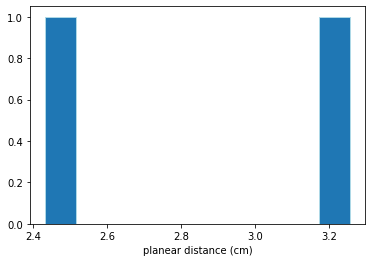

In [41]:
distances = [d for _, d, l in dataset if l > 0.2]

plt.hist(distances, edgecolor="lightblue")
plt.xlabel("planear distance (cm)")
plt.show()

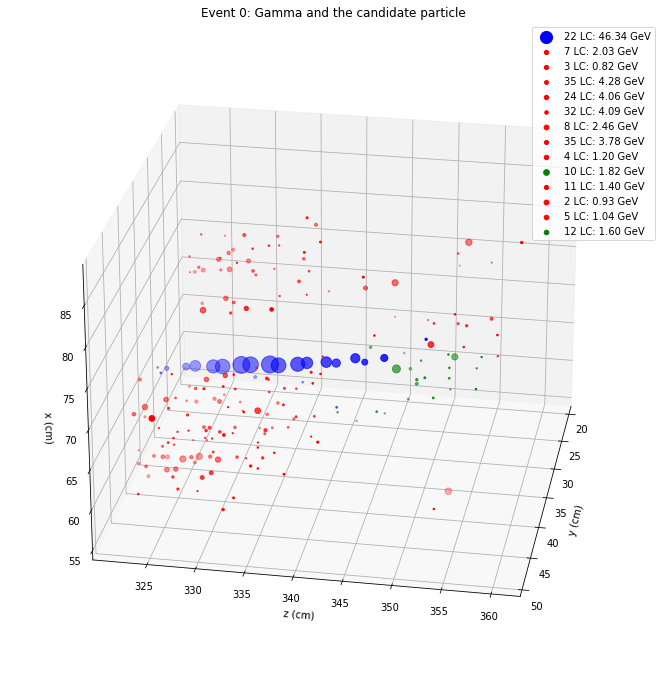

In [43]:
vertices_x = vertices_x_[eid]
vertices_y = vertices_y_[eid]
vertices_z = vertices_z_[eid]
vertices_e = vertices_energy_[eid]

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f"Event {eid}: Gamma and the candidate particle")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_zlabel("z (cm)")

bve = vertices_e[bigT]
ax.scatter(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT], s=bve*50, c="blue", label=f"{len(bve)} LC: {sum(bve):.2f} GeV")

for recoTxId, distance, label in dataset:
    rve = vertices_e[recoTxId]
    clr = "green" if label > 0.2 else "red"
    ax.scatter(vertices_x[recoTxId], vertices_y[recoTxId], vertices_z[recoTxId], s=rve*50, c=clr, label=f"{len(rve)} LC: {sum(rve):.2f} GeV")

ax.view_init(25, 10, "x")
plt.legend()
plt.show()

# Evaluation

In [45]:
from reco.evaluation import evaluate
import awkward as ak

t_indices = vertices_indices_[eid][bigT:bigT+1]
t_energy = vertices_energy_[eid][bigT:bigT+1]
t_multi = vertices_multi_[eid][bigT:bigT+1]

st_indices = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
st_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print("Reco tracksters:", len(t_indices), "Sim tracksters:", len(st_indices))

Reco tracksters: 1 Sim tracksters: 1


In [46]:
print(f"Baseline (energy {sum(t_energy[0]):.2f} GeV):: ")
Pr, Re, F1 = evaluate(t_indices, st_indices, t_energy, st_energy, t_multi, st_multi)
print(f"\tPrecision: {Pr:.2f} | Recall: {Re:.2f} | F1: {F1:.2f}")

Baseline (energy 46.34 GeV):: 
	Precision: 0.91 | Recall: 0.16 | F1: 0.19


In [49]:
# after connecting the trackster
# create the merge map using the label
selected_t_indexes = [i for i, _, l in dataset if l > 0.2]
selected_t_indexes.append(bigT)

r_indices = [ak.flatten(vertices_indices_[eid][selected_t_indexes])]
r_energy = [ak.flatten(vertices_energy_[eid][selected_t_indexes])]
r_multi = [ak.flatten(vertices_multi_[eid][selected_t_indexes])]

print("Reco tracksters:", len(r_indices), "Sim tracksters:", len(st_indices))

Reco tracksters: 1 Sim tracksters: 1


In [50]:
print(f"After connection (energy {sum(r_energy[0]):.2f} GeV):")
Pr, Re, F1 = evaluate(r_indices, st_indices, r_energy, st_energy, r_multi, st_multi)
print(f"\tPrecision: {Pr:.2f} | Recall: {Re:.2f} | F1: {F1:.2f}")

After connection (energy 49.76 GeV):
	Precision: 0.77 | Recall: 0.27 | F1: 0.31


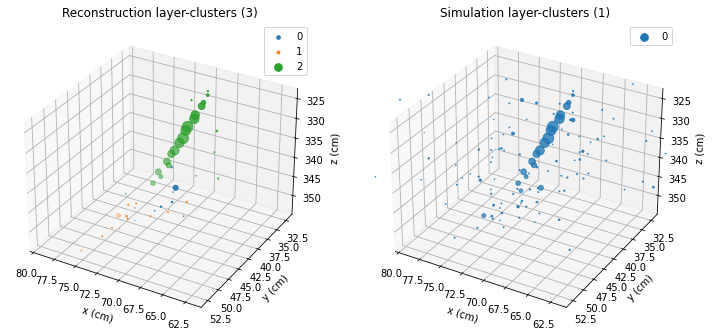

In [56]:
from reco.plotting import plot_sim_reco

ax1, ax2 = plot_sim_reco(
    vertices_x_[eid][selected_t_indexes],
    vertices_y_[eid][selected_t_indexes],
    vertices_z_[eid][selected_t_indexes],
    vertices_energy_[eid][selected_t_indexes]*10,
    simtracksters["stsSC_vertices_x"].array()[eid],
    simtracksters["stsSC_vertices_y"].array()[eid],
    simtracksters["stsSC_vertices_z"].array()[eid],
    simtracksters["stsSC_vertices_energy"].array()[eid]*10,
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    energy_threshold=1,
)
